In [1]:
# import sentiment as sentimentinterface
import timeit
import numpy as np

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
%matplotlib inline

In [2]:
def train_classifier(X, y):
    """Train a classifier using the given training data.

    Trains logistic regression on the input data with default parameters.
    """
    from sklearn.linear_model import LogisticRegression
    cls = LogisticRegression(random_state=0, solver='lbfgs', max_iter=10000)
    cls.fit(X, y)
    return cls

def evaluate(X, yt, cls, name='data'):
    """Evaluated a classifier on the given labeled data using accuracy."""
    from sklearn import metrics
    yp = cls.predict(X)
    acc = metrics.accuracy_score(yt, yp)
    print("  Accuracy on %s  is: %s" % (name, acc))

In [3]:
def read_files(tarfname):
    """Read the training and development data from the sentiment tar file.
    The returned object contains various fields that store sentiment data, such as:

    train_data,dev_data: array of documents (array of words)
    train_fnames,dev_fnames: list of filenames of the doccuments (same length as data)
    train_labels,dev_labels: the true string label for each document (same length as data)

    The data is also preprocessed for use with scikit-learn, as:

    count_vec: CountVectorizer used to process the data (for reapplication on new data)
    trainX,devX: array of vectors representing Bags of Words, i.e. documents processed through the vectorizer
    le: LabelEncoder, i.e. a mapper from string labels to ints (stored for reapplication)
    target_labels: List of labels (same order as used in le)
    trainy,devy: array of int labels, one for each document
    """
    import tarfile
    tar = tarfile.open(tarfname, "r:gz")
    trainname = "train.tsv"
    devname = "dev.tsv"
    for member in tar.getmembers():
        if 'train.tsv' in member.name:
            trainname = member.name
        elif 'dev.tsv' in member.name:
            devname = member.name


    class Data: pass
    sentiment = Data()
    print("-- train data")
    sentiment.train_data, sentiment.train_labels = read_tsv(tar,trainname)
    print(len(sentiment.train_data))

    print("-- dev data")
    sentiment.dev_data, sentiment.dev_labels = read_tsv(tar, devname)
    print(len(sentiment.dev_data))
    print("-- transforming data and labels")
    # Convert a collection of text documents to a matrix of token counts
    from sklearn.feature_extraction.text import CountVectorizer
    sentiment.count_vect = CountVectorizer()
    sentiment.trainX = sentiment.count_vect.fit_transform(sentiment.train_data)
    sentiment.devX = sentiment.count_vect.transform(sentiment.dev_data)
    from sklearn import preprocessing
    # Encode labels with value between 0 and n_classes-1.
    sentiment.le = preprocessing.LabelEncoder()
    sentiment.le.fit(sentiment.train_labels)
    sentiment.target_labels = sentiment.le.classes_
    sentiment.trainy = sentiment.le.transform(sentiment.train_labels)
    sentiment.devy = sentiment.le.transform(sentiment.dev_labels)
    tar.close()
    return sentiment


def new_read_files(tarfname,tfidf=True,min_df=1,max_df=1.0,ngram_range=(1,1)):

    import tarfile
    tar = tarfile.open(tarfname, "r:gz")
    trainname = "train.tsv"
    devname = "dev.tsv"
    for member in tar.getmembers():
        if 'train.tsv' in member.name:
            trainname = member.name
        elif 'dev.tsv' in member.name:
            devname = member.name
    class Data: pass
    sentiment = Data()
    print("-- train data")
    sentiment.train_data, sentiment.train_labels = read_tsv(tar,trainname)
    print(len(sentiment.train_data))

    print("-- dev data")
    sentiment.dev_data, sentiment.dev_labels = read_tsv(tar, devname)
    print(len(sentiment.dev_data))
    print("-- transforming data and labels")
    # Convert a collection of text documents to a matrix of token counts
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.feature_extraction.text import TfidfVectorizer
    # stop_words=badwords,min_df=1,max_df=0.4
    
    if tfidf == False:
        sentiment.count_vect = CountVectorizer(min_df=min_df,max_df=max_df,ngram_range=ngram_range)
        sentiment.trainX = sentiment.count_vect.fit_transform(sentiment.train_data)
        sentiment.devX = sentiment.count_vect.transform(sentiment.dev_data)
    else:
        sentiment.count_vect = TfidfVectorizer(min_df=min_df,max_df=max_df,ngram_range=ngram_range)
        sentiment.trainX = sentiment.count_vect.fit_transform(sentiment.train_data)
        sentiment.devX = sentiment.count_vect.transform(sentiment.dev_data)

    from sklearn import preprocessing
    # Encode labels with value between 0 and n_classes-1.
    sentiment.le = preprocessing.LabelEncoder()
    sentiment.le.fit(sentiment.train_labels)
    sentiment.target_labels = sentiment.le.classes_
    sentiment.trainy = sentiment.le.transform(sentiment.train_labels)
    sentiment.devy = sentiment.le.transform(sentiment.dev_labels)
    tar.close()
    return sentiment

def read_tsv(tar, fname):
    member = tar.getmember(fname)
    print(member.name)
    tf = tar.extractfile(member)
    data = []
    labels = []
    toxic_count = 0
    not_toxic_count = 0
    batch_size = 20000
    for line in tf:
        line = line.decode("utf-8")
        if len(line.strip().split("\t")) != 2:
            continue
        (label,text) = line.strip().split("\t")
        if label=="TOXIC":
            toxic_count += 1
        else:
            not_toxic_count += 1
        labels.append(label)
        data.append(text)
        batch_size-=1
        if batch_size == 0:
            break
    print(member.name + " has {} TOXIC data and {} NOT_TOXIC data".format(toxic_count,not_toxic_count))
    return data, labels

In [4]:
def tsv_new_read_files(tfidf=True,min_df=1,max_df=1.0,ngram_range=(1,1)):

    trainname = "train.csv"
    devname = "dev.csv"
            
            
    class Data: pass
    sentiment = Data()
    print("-- train data")
    #read train_data and train_labels and print out the length
    sentiment.train_data, sentiment.train_labels = read_csv(trainname)
    len_trainset = len(sentiment.train_data)
    print("training dataset amount: {}".format(len_trainset))
    n_train = sentiment.train_labels.count("TOXIC")
    print("toxic in train set: {}  ({:.2f}%)".format(n_train,(n_train/len_trainset)*100))
    print("non-toxic in train set : {}".format(len_trainset-n_train))
    print("-- dev data")
    #read dev_data and dev_labels and print out the length
    sentiment.dev_data, sentiment.dev_labels = read_csv(devname)
    len_devset= len(sentiment.dev_data)
    print("dev dataset amount: {} ".format(len_devset))
    n_dev = sentiment.dev_labels.count("TOXIC")
    print("toxic in dev set : {}  ({:.2f}%)".format(n_dev, (n_dev / len_devset)*100))
    print("non-toxic in dev set : {}  ".format(len_devset-n_dev))
    #print("-- transforming data and labels")
    
    
    # Convert a collection of text documents to a matrix of token counts
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.feature_extraction.text import TfidfVectorizer
    # stop_words=badwords,min_df=1,max_df=0.4
    
    if tfidf == False:
        sentiment.count_vect = CountVectorizer(min_df=min_df,max_df=max_df,ngram_range=ngram_range)
        sentiment.trainX = sentiment.count_vect.fit_transform(sentiment.train_data)
        sentiment.devX = sentiment.count_vect.transform(sentiment.dev_data)
    else:
        sentiment.count_vect = TfidfVectorizer(min_df=min_df,max_df=max_df,ngram_range=ngram_range)
        sentiment.trainX = sentiment.count_vect.fit_transform(sentiment.train_data)
        sentiment.devX = sentiment.count_vect.transform(sentiment.dev_data)

    from sklearn import preprocessing
    # Encode labels with value between 0 and n_classes-1.
    sentiment.le = preprocessing.LabelEncoder()
    sentiment.le.fit(sentiment.train_labels)
    sentiment.target_labels = sentiment.le.classes_
    sentiment.trainy = sentiment.le.transform(sentiment.train_labels)
    sentiment.devy = sentiment.le.transform(sentiment.dev_labels)
    return sentiment

def read_csv(fname):
    import csv
    data = []
    labels = []
    if fname == "train.csv":
        count = 50000
    else:
        count = 10000
    with open(fname,encoding='UTF-8') as f:
        reader = csv.reader(f)
        for row in reader:
            if row[0]=="toxic":
                labels.append("TOXIC")
            else:
                labels.append("NOT_TOXIC")
            data.append(row[1])
            count -=1 
            if count == 0:
                break
    return data, labels

In [5]:
print("Reading data")
sentiment0 = tsv_new_read_files(tfidf=True,max_df=0.5)
print("~"*120)
sentiment1 = tsv_new_read_files(tfidf=True,min_df=1,max_df=0.5,ngram_range=(1,2))

Reading data
-- train data
training dataset amount: 50000
toxic in train set: 4839  (9.68%)
non-toxic in train set : 45161
-- dev data
dev dataset amount: 10000 
toxic in dev set : 1016  (10.16%)
non-toxic in dev set : 8984  
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
-- train data
training dataset amount: 50000
toxic in train set: 4839  (9.68%)
non-toxic in train set : 45161
-- dev data
dev dataset amount: 10000 
toxic in dev set : 1016  (10.16%)
non-toxic in dev set : 8984  


In [6]:
array = sentiment0.trainX # the vocabulary dictionary and return term-document matrix
print(sentiment0.train_data[4000]) # the first entry in training data
print(sentiment0.train_labels[4000])
print('~'*120)
print(sentiment0.train_data[2000])
print(sentiment0.train_labels[2000])

Dihydrous oxide 

It bothers me how my Harvard professor says Dihydrous oxide is water, yet you idiots continually revert it without even looking it up. Literally, just try it. 71.115.3.186
TOXIC
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ahhh thankyou so much Anna!!
NOT_TOXIC


In [7]:
sentiment = sentiment0
print(sentiment.trainX.shape[1])
print((sentiment.count_vect.get_feature_names()[36392])) # map id to word
print((sentiment.count_vect.get_feature_names()[17101]))

94778
glider
celeberties


In [8]:
print('target labels ', sentiment0.target_labels)
print('target labels ', sentiment0.trainy[:5]) # show the labels of the first 5 training examples
print(list(sentiment0.le.classes_))
print(list(sentiment0.le.transform(['NOT_TOXIC', 'TOXIC'])))
print(list(sentiment0.le.inverse_transform(list(sentiment0.trainy[:7]))))

target labels  ['NOT_TOXIC' 'TOXIC']
target labels  [1 0 0 0 0]
['NOT_TOXIC', 'TOXIC']
[0, 1]
['TOXIC', 'NOT_TOXIC', 'NOT_TOXIC', 'NOT_TOXIC', 'NOT_TOXIC', 'NOT_TOXIC', 'NOT_TOXIC']


In [9]:
# from warnings import simplefilter
# import classify
# # ignore all future warnings
# simplefilter(action='ignore', category=FutureWarning)

cls0 = train_classifier(sentiment0.trainX, sentiment0.trainy)
evaluate(sentiment0.trainX, sentiment0.trainy, cls0, 'train')
evaluate(sentiment0.devX, sentiment0.devy, cls0, 'dev')

# trainCoeff = dict(zip(new_sentiment.count_vect.get_feature_names(), new_cls.coef_.flatten().tolist()))

  Accuracy on train  is: 0.95494
  Accuracy on dev  is: 0.9468


In [10]:
cls1 = train_classifier(sentiment1.trainX, sentiment1.trainy)
evaluate(sentiment1.trainX, sentiment1.trainy, cls1, 'train')
evaluate(sentiment1.devX, sentiment1.devy, cls1, 'dev')

  Accuracy on train  is: 0.94596
  Accuracy on dev  is: 0.9406


In [11]:
cls = cls0
sentiment = sentiment0
coefficients=cls.coef_[0]
print(cls.classes_)
print(cls.coef_)
print(cls.coef_.shape)
k = 20
# get top_k toxic coefficients -> positive coefficients tends to make prediction toxic
top_k =np.argsort(coefficients)[-k:]
top_k_words = []

print('-'*50)
print('Top k=%d' %k)
print('-'*50)

for i in top_k:
    print(sentiment.count_vect.get_feature_names()[i])
    top_k_words.append(sentiment.count_vect.get_feature_names()[i])

print('-'*50)
print('Bottom k=%d' %k)
print('-'*50)
#top_k = np.argpartition(coefficients, -k)[-k:]
bottom_k =np.argsort(coefficients)[:k]
bottom_k_words = []
#print(top_k)
for i in bottom_k:
    print(sentiment.count_vect.get_feature_names()[i])
    bottom_k_words.append(sentiment.count_vect.get_feature_names()[i])

#print(sentiment.count_ve

[0 1]
[[ 0.03134588 -0.5885797  -0.02786178 ... -0.00074604 -0.00074604
  -0.00074604]]
(1, 94778)
--------------------------------------------------
Top k=20
--------------------------------------------------
idiots
dumb
penis
faggot
you
gay
cunt
bitch
hell
asshole
dick
suck
crap
bullshit
ass
idiot
stupid
shit
fucking
fuck
--------------------------------------------------
Bottom k=20
--------------------------------------------------
thank
please
talk
thanks
for
may
article
help
welcome
could
if
at
in
would
best
as
redirect
there
but
sources


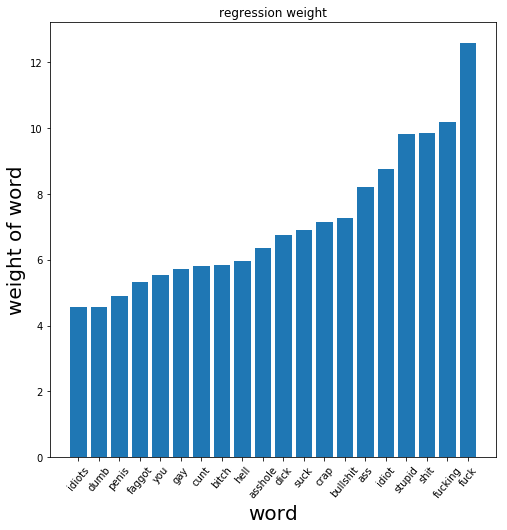

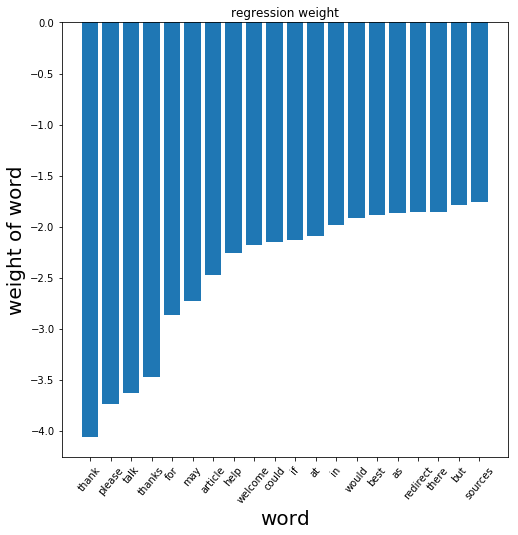

In [12]:
def plot_bar_x(k_words,_k,coeff):
    # this is for plotting purpose
    index = np.arange(len(k_words))
    wordsCoeff = []
    for i in _k:
        wordsCoeff.append(coeff[i])
    plt.figure(figsize=[8,8])
    plt.bar(index, wordsCoeff)
    plt.xlabel('word', fontsize=20)
    plt.ylabel('weight of word', fontsize=20)
    plt.xticks(index, k_words, fontsize=10, rotation=50)
    plt.title('regression weight')
    plt.show()
plot_bar_x(top_k_words, top_k, coefficients)
plot_bar_x(bottom_k_words, bottom_k, coefficients)

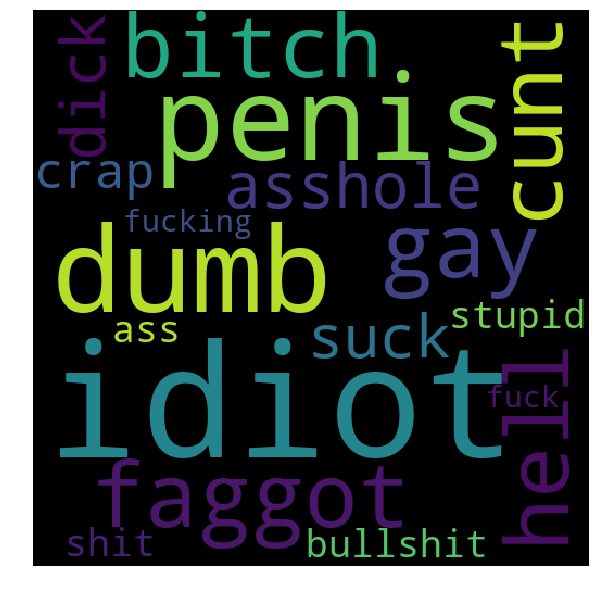

In [13]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import random as random 
from PIL import Image
import urllib  
import requests

toxic_words = ''
for tw in top_k_words:
    toxic_words = toxic_words + tw + ' '

stopwords = set(STOPWORDS) 

wordcloud = WordCloud(width = 512, height = 512, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(toxic_words) 

  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

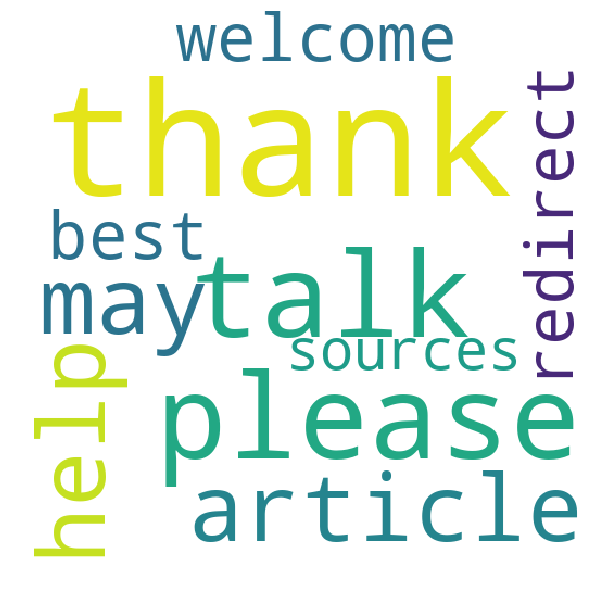

In [14]:
not_toxic_words = ''
for tw in bottom_k_words:
    not_toxic_words = not_toxic_words + tw + ' '

stopwords = set(STOPWORDS) 

wordcloud = WordCloud(width = 512, height = 512, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(not_toxic_words) 

  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

  Accuracy on dev sentence with top k toxic words  is: 0.9288777698355969


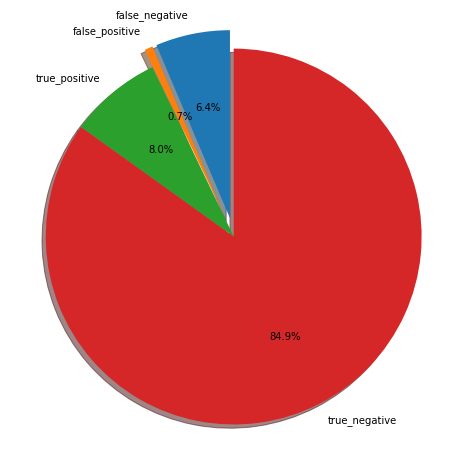

In [15]:
top_k_reviews = []
top_k_labels = []
for j in range(len(sentiment.dev_data)):
    review = sentiment.dev_data[j]
    for word in top_k_words:
        if word in review:
            top_k_reviews.append(review)
            top_k_labels.append(sentiment.dev_labels[j])
            break
    
dev_top_k_X = sentiment.count_vect.transform(top_k_reviews)
evaluate(dev_top_k_X, sentiment.le.transform(top_k_labels), cls, 'dev sentence with top k toxic words')

#=============================================================================================================

import matplotlib.pyplot as plt
y = cls.predict(dev_top_k_X)
yt = sentiment.le.transform(top_k_labels)
false_negative = 0
true_negative = 0 
false_positive = 0
true_positive = 0
for i in range(len(y)):
    if y[i]==1 and yt[i]==1:
        true_positive += 1
    elif y[i]==1 and yt[i]==0:
        false_positive += 1
    elif y[i]==0 and yt[i]==0:
        true_negative += 1
    else:
        false_negative += 1
        
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'false_negative', 'false_positive', 'true_positive' , 'true_negative'
sizes = [false_negative,  false_positive, true_positive, true_negative]
explode = (0.1, 0.1, 0, 0) 

fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


  Accuracy on dev sentence with bottom k non-toxic words  is: 0.949098281933625


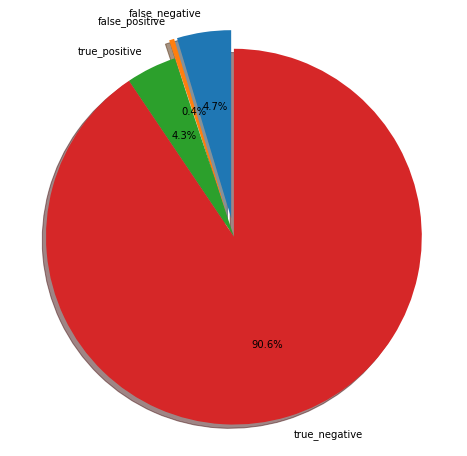

In [16]:
bottom_k_reviews = []
bottom_k_labels = []
for j in range(len(sentiment.dev_data)):
    review = sentiment.dev_data[j]
    for word in bottom_k_words:
        if word in review:
            bottom_k_reviews.append(review)
            bottom_k_labels.append(sentiment.dev_labels[j])
            break
    
dev_bottom_k_X = sentiment.count_vect.transform(bottom_k_reviews)
evaluate(dev_bottom_k_X, sentiment.le.transform(bottom_k_labels), cls, 'dev sentence with bottom k non-toxic words')

#=============================================================================================================

import matplotlib.pyplot as plt
y = cls.predict(dev_bottom_k_X)
yt = sentiment.le.transform(bottom_k_labels)
false_negative = 0
true_negative = 0 
false_positive = 0
true_positive = 0
for i in range(len(y)):
    if y[i]==1 and yt[i]==1:
        true_positive += 1
    elif y[i]==1 and yt[i]==0:
        false_positive += 1
    elif y[i]==0 and yt[i]==0:
        true_negative += 1
    else:
        false_negative += 1
        
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'false_negative', 'false_positive', 'true_positive' , 'true_negative'
sizes = [false_negative,  false_positive, true_positive, true_negative]
explode = (0.1, 0.1, 0, 0) 

fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


In [17]:
overconfident = []
overconfident_lab = []
overconfident_y = []
overconfident_yp = []
overconfident_index = []
y = cls.predict(sentiment.devX)
yp = cls.predict_proba(sentiment.devX)
yt = sentiment.devy
for j in range(len(sentiment.dev_data)):
    if y[j]!=yt[j] and (yp[j][0]>=0.9 or yp[j][1]>=0.9):
        overconfident.append(sentiment.dev_data[j])
        overconfident_lab.append(sentiment.dev_labels[j])
        overconfident_y.append(y[j])
        overconfident_yp.append(yp[j])
        overconfident_index.append(j)
# for ov in overconfident:
#     print(ov)

print(overconfident[-1])
print(overconfident_lab[-1])
print(overconfident_y[-1])
print(overconfident_yp[-1])

# help, idiots 

Mistakes

Since you idiots won't let me edit this page, I'm just pointing out some mistakes. There have been 105 1/2 episodes to air, not 104 1/2. Also, you have the episodes Help Wanted/Reef Blower/Tea At The Treedome to have first aired May 1, 1999 and then as a normal episode on July 17, 1999. They didn't air as an actual episode until July 24, 1999. Change it. Now.
TOXIC
0
[0.97457088 0.02542912]
